#Background

Few Shot classification is a task to classify a class only from a few label. Few Shot classification is really important because  usually deep learning algorithm need a lot of clean data and label to perform well on classification task.
labelling clean data is not easy and can be very expensive. for example when we want to train a deep learning model to classify new disease from x-ray images, labelling this kind of data is really expensive and possibly rare(there is little patient), so to perform well on this kind of task we need algorithm that can do few shot classification.

 In this colab we will use omniglot dataset to do few shot learning. We will also use <a href = 'https://www.pytorchlightning.ai/'>pytorch lightning</a> as the deeplearning framework.

#Import Library

In [ ]:
#install pytorch lightning
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 14.5 MB/s 
     |████████████████████████████████| 419 kB 62.0 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
     |████████████████████████████████| 140 kB 57.9 MB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 144 kB 45.5 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 271 kB 52.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import Omniglot
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from torch.utils.data import Dataset
import random
from tqdm import tqdm

#Dataset

Here we will use <a href = "https://github.com/brendenlake/omniglot">Omniglot</a> dataset, it is a dataset of handwritten digit with size (105 x 105). Some people call it MNIST transpose because there is a lot of class and only few(20) example for each class. 

To train N-way and K-shot classification task we need to divide  dataset into episode,which contain N different character with K support image to create the label,we will also use query image to train the algorithm

episode is not only used by prototypical network but a lot of other algorithm also use this kind of episode like <a href = "https://arxiv.org/abs/1703.03400">MAML</a>  and <a href = "https://arxiv.org/abs/1605.06065?context=cs">MANN</a>

In [ ]:
#Download the omniglot dataset
Omniglot(os.getcwd(),download = True)
#you can see the folder named omniglot-py in the colab file,there you can see for yourself the digit example

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /content/omniglot-py/images_background.zip to /content/omniglot-py


Dataset Omniglot
    Number of datapoints: 19280
    Root location: /content/omniglot-py

In [ ]:
from torchvision.io import read_image

#Pytorch Dataset class 
class MyOmniglot(Dataset):
  def __init__(self,img_dir,numSample = 20):
    #image folder direction
    self.img_dir = img_dir
    self.numSample = numSample

  def __len__(self):
    return len(self.img_dir)

  # to sample from this dataset from folder direction
  def __getitem__(self, idx):
    characterNow = self.img_dir[idx]
    charImage = []
    directionToLoop = os.listdir(characterNow) 
    random.shuffle(directionToLoop)
    for charName in directionToLoop  :
      charPath = characterNow + "/" + charName
      image = read_image(charPath)
      charImage.append(image)
      if len(charImage) == self.numSample :
        break

    charImage = torch.stack(charImage)
    # preprocess image
    # divide by 255(max pixel)
    # turn black into white and white into black
    charImage = (1 - charImage/255)
    return charImage

#Algorrithm

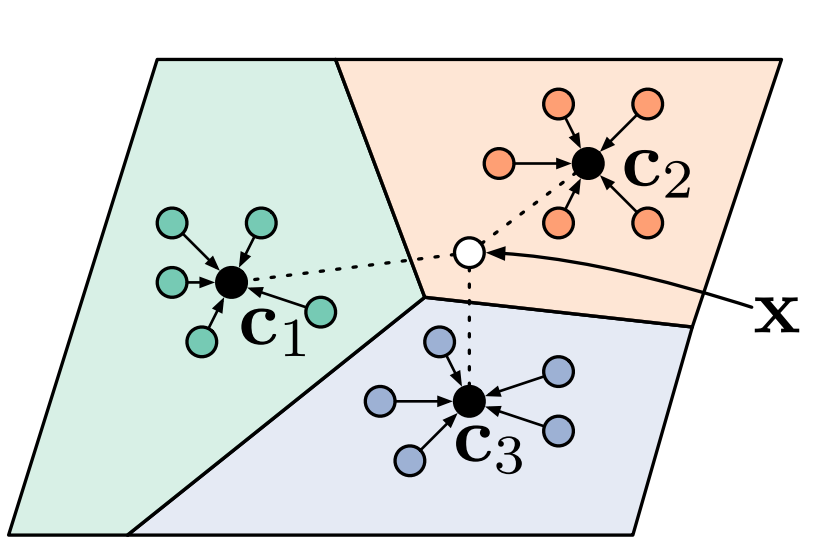

We will use <a href = 'https://arxiv.org/pdf/1703.05175.pdf'> Prototypical Networks</a> to do few shot learning.

this algorithm learn a neural network that map examples image from a class(support set) into a vector embedding that represent all image in that class (class prototype), the same neural network will also be used to classify new example based on similarity with the class prototype. 

$${c_k = \frac{1}{|S_k|} ∑_{(x_i,y_i)\in S_k} f_{\phi}(x_i)}$$
with : <br>
${c_k}$ : class k prototype <br>
${S_k}$ : support sample of class k <br>
$f_{\phi}(x_i)$ : neural network with parameter $\phi$

to classify example based on prototype we use this formula :
$${p_{\phi}(y = k|x) = \frac{exp(-d(f_{\phi}(x),c_k) )}{∑_{k'}exp(-d(f_{\phi}(x),c_{k'}))}}$$

with : <br>
${p_{\phi}(y = k|x)}$ : the probability a data x is class k <br>
${exp(x)}$ : the exponential function (${e^x}$),where e is the euler's number <br>
${d}$ : is the distance function,here we will use euclidean distance <br>


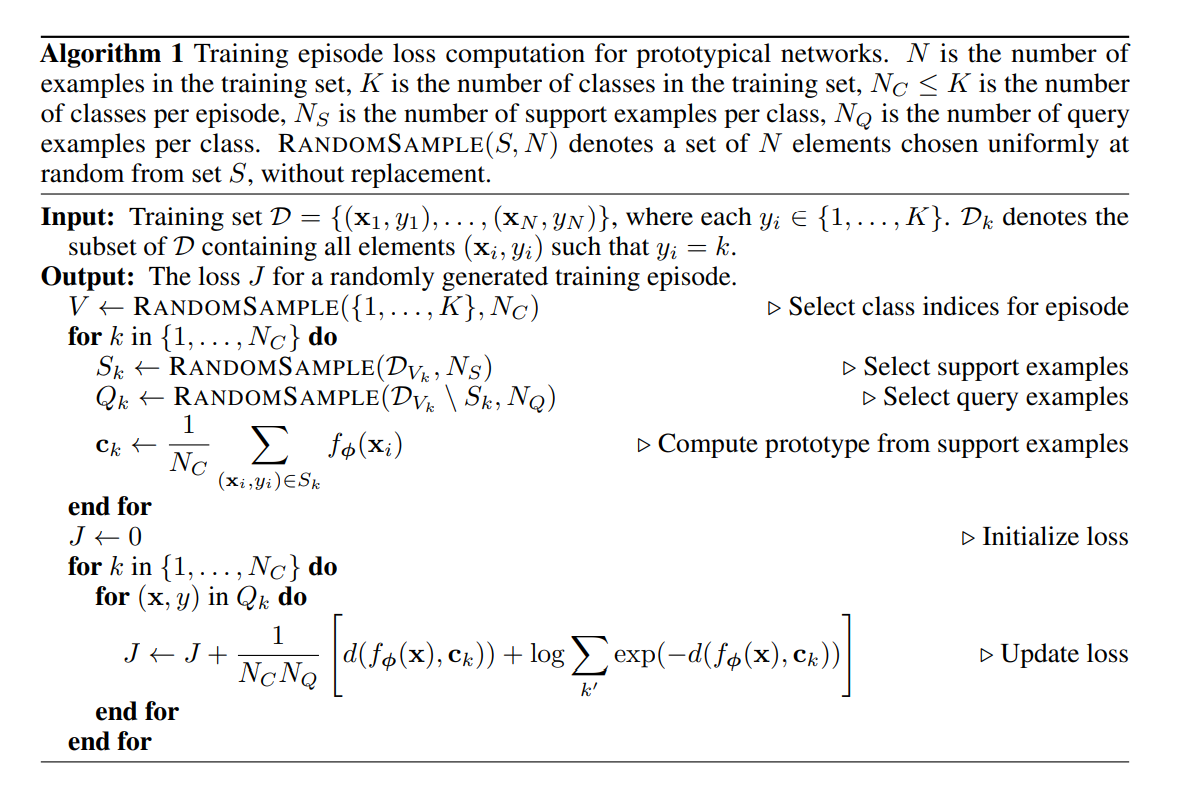

before processing throught neural network we interpolate the image so it have 28x28 size.

the neural network model we use here is 4 layer convolutional neural network with 64 hidden dimmension, instance norm,relu and max pooling.

In [ ]:
class ConvBlock(nn.Module) :
  def __init__(self,inDim,outDim):
    super(ConvBlock, self).__init__()
    self.block = torch.nn.Sequential(
        nn.Conv2d(inDim,outDim,(3,3),(1,1),(1,1)),
        nn.InstanceNorm2d(outDim),
        nn.ReLU(),
        nn.MaxPool2d((2,2),(2,2))
    )
  def forward(self, x):
    return self.block(x)

In [ ]:
class Interpolate(nn.Module):
  def __init__(self, size):
    super(Interpolate, self).__init__()
    self.size = size
      
  def forward(self, x):
    x = F.interpolate(x,self.size) 
    return x

In [ ]:
class LitClassifier(pl.LightningModule):
  def __init__(self,num_eps,n_way,k_shot,numSample):
    super().__init__()
    # Model Setting
    self.model = torch.nn.Sequential(
        Interpolate((28,28)),
        ConvBlock(1,64),
        ConvBlock(64,64),
        ConvBlock(64,64),
        nn.Conv2d(64,64,(3,3),(1,1)),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten()
    )

    # Optimizer Setting 
    self.lr = 1e-3
    self.weight_decay = 1e-1

    # Experiment Setting
    self.num_eps = num_eps
    self.n_way = n_way
    self.k_shot = k_shot
    self.numSample = numSample


  def forward(self,supportSet,querySet):
    # Support set : Class x Num_support x channel x widht x height
    # Querry set : Num_query x channel x widht x height
    cNum,supNum,chn,w,h = supportSet.shape
    supportSet = supportSet.reshape(cNum*supNum,chn,w,h)
    
    supportEmbed = self.model(supportSet)
    supportEmbed = supportEmbed.reshape(cNum,supNum,-1)
    supportEmbed = torch.mean(supportEmbed,-2)
    queryEmbed = self.model(querySet)
    # euclidean distance
    pred = -2*(queryEmbed @ supportEmbed.transpose(-1,-2) )+ (supportEmbed**2).transpose(-1,-2).sum(-2,keepdims=True) + (queryEmbed**2).sum(-1,keepdims=True)
    pred = torch.softmax(-pred,-1)
    return pred
  
  def processBatch(self,batch) :
    # batch shape is num_eps*n_way x numSample x feature(channel x height x width)

    # reshape batch
    x = batch.reshape(self.num_eps*self.n_way*self.numSample, 1, 105, 105) 
    # creating the label for training or eval
    label = torch.ones(self.num_eps,self.n_way,self.numSample)
    label = label*torch.arange(self.n_way).reshape(1,self.n_way,1)

    # forward model
    embed = self.model(x).reshape(self.num_eps,self.n_way,self.numSample,-1)

    # split into support(for prototype) and query
    supportSet = embed[:,:,:self.k_shot,:]
    supportSet = torch.mean(supportSet,-2)
    querySet = embed[:,:,self.k_shot:,:]
    querySet = querySet.reshape(querySet.shape[0],querySet.shape[1]*querySet.shape[2],-1)

    #split query label to train or eval
    queryLabel = label[:,:,self.k_shot:]
    queryLabel = queryLabel.reshape(queryLabel.shape[0]*queryLabel.shape[1]*queryLabel.shape[2])
    queryLabel = queryLabel.to(torch.long)

    # euclidean distance formula
    distance =  -2*(querySet @ supportSet.transpose(-1,-2)) + (supportSet**2).transpose(-1,-2).sum(-2,keepdims=True) + (querySet**2).sum(-1,keepdims=True)
    distance = distance.reshape(distance.shape[0]*distance.shape[1],distance.shape[2])
    return distance,queryLabel

  def validation_step(self, batch, batch_idx,callFromTest = False):
    distance,queryLabel = self.processBatch(batch)
  
    labelPred = distance.argmin(-1)
    accuracy = (labelPred == queryLabel)
    accuracy = torch.sum(accuracy)
    
    if callFromTest :
      self.log("test_acc", accuracy/len(queryLabel))
    else :
      self.log("validation_acc", accuracy/len(queryLabel))
    
    return accuracy

  def test_step(self, batch, batch_idx):
    self.validation_step(batch, batch_idx,True)
  
  def training_step(self, batch, batch_idx):
    distance,queryLabel = self.processBatch(batch)
    
    loss = -torch.log_softmax(-distance,-1)
    loss = loss[torch.arange(len(loss)),queryLabel]
    loss = torch.mean(loss)
    
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,weight_decay= self.weight_decay )
    return optimizer

#Start Training

In [ ]:
class OmniglotExperiment() :
  def __init__(self) :
    #Experiment Config
    self.num_sample_training = 20
    self.n_way = 5
    self.k_shot = 1
    self.num_eps = 8
    self.max_epoch = 20

    img_folder_dir = []
    basePath = os.getcwd() + '/omniglot-py/images_background'
    for omniglotCharType in os.listdir(basePath) :
      for charNow in os.listdir(basePath + '/' + omniglotCharType) :
        img_folder_dir.append(basePath + "/" + omniglotCharType + "/" + charNow)

    dataset_train = MyOmniglot(img_folder_dir[:500],numSample = self.num_sample_training)
    dataset_eval = MyOmniglot(img_folder_dir[500:700],numSample = self.num_sample_training)
    lastBatchRemain = (len(img_folder_dir) - 700) %(self.n_way)
    dataset_test = MyOmniglot(img_folder_dir[700:-lastBatchRemain],numSample = self.num_sample_training)

    self.train_loader = DataLoader(dataset_train,batch_size=self.n_way*self.num_eps, shuffle=True,drop_last=True)
    self.val_loader = DataLoader(dataset_eval,batch_size=self.n_way*self.num_eps, shuffle=True,drop_last=True)
    self.test_loader = DataLoader(dataset_test,batch_size=self.n_way*self.num_eps, shuffle=True,drop_last=True)

    self.model = LitClassifier(self.num_eps,self.n_way,self.k_shot,self.num_sample_training)
    self.logger = pl.loggers.CSVLogger(os.getcwd() + "/logs", name="trial_Omniglot")
    self.trainer = pl.Trainer(logger = self.logger,max_epochs=self.max_epoch)

  def loadModel(self,checkpoint_path) :
    self.model = LitClassifier.load_from_checkpoint(
        checkpoint_path,
        num_eps = self.num_eps,
        n_way = self.n_way,
        k_shot = self.k_shot,
        numSample = self.num_sample_training)

  def start_train(self,checkpoint_path = None) :
    self.trainer.fit(model = self.model, 
                     train_dataloaders = self.train_loader,
                     val_dataloaders = self.val_loader,
                     ckpt_path = checkpoint_path )
  
  def testModel(self,numTest = 5) :
    countBatch = 0
    total = 0 
    for itr in tqdm(range(numTest)) :
      for batch in self.test_loader :
        countBatch = countBatch + 1
        distance,queryLabel = self.model.processBatch(batch)
        
        labelPred = distance.argmin(-1)
        accuracy = (labelPred == queryLabel)
        accuracy = torch.sum(accuracy)
        total = total + accuracy/len(queryLabel)
    accAll = total/countBatch
    return accAll

In [ ]:
experiment = OmniglotExperiment()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# you can see the training progress in the logs folder in colab
experiment.start_train()


  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 111 K 
-------------------------------------
111 K     Trainable params
0         Non-trainable params
111 K     Total params
0.446     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
experiment.testModel()

100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


tensor(0.8925)

# Test on other dataset

In [ ]:
from keras.datasets import mnist

In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [ ]:
supportSet = []
querySet = []
queryLabel = []
mnistDigit = [0,1,2,3,4]
for i in range(experiment.k_shot) :
  tempSet = []
  for digit in mnistDigit :
    dataNow = x_train[y_train == digit][i].reshape(1,28,28)
    # dataNow = resize(dataNow,(1,105,105))
    dataNow = torch.as_tensor(dataNow).float()/255
    tempSet.append(dataNow)
  tempSet = torch.stack(tempSet,0)
  supportSet.append(tempSet)
supportSet = torch.stack(supportSet,0)
supportSet = supportSet.transpose(0,1)

for i in range(len(y_test)) :
  if y_test[i] in mnistDigit :
    dataNow = x_test[i].reshape(1,28,28)
    # dataNow = resize(dataNow,(1,105,105))
    dataNow = torch.as_tensor(dataNow).float()/255
    querySet.append(dataNow)
    queryLabel.append(y_test[i])
querySet = torch.stack(querySet,0)
queryLabel = torch.LongTensor(queryLabel)

In [ ]:
experiment.model.eval()
y_pred = experiment.model.forward(supportSet,querySet)

In [ ]:
torch.sum(queryLabel[0:len(querySet)] == y_pred.argmax(-1))/len(querySet)

tensor(0.8274)

# Reference

- <a href = 'https://arxiv.org/abs/1703.03400'>Prototypical Networks for Few-shot Learning
</a>
- <a href = 'https://arxiv.org/abs/1605.06065'>One-shot Learning with Memory-Augmented Neural Networks
</a>
- <a href = 'https://arxiv.org/abs/1703.03400'> Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks
</a>